In [206]:
#Importing the libraries
import numpy as np
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns 
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier





import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [207]:

# Read the CSV file
df = pd.read_csv('../data/heart.csv')
# Print the contents of the DataFrame
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Data Pre Processing

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
# Count of rows and columns in this dataset
df.shape

(918, 12)

We already check in Data Cleaning file there is no any NULL and Missing values in dataset.But, there are many 0's in columns values which are not good for our prediction.

In [5]:
#check how  many zeros there are in each column

for column_name in df.columns:
    count = (df[column_name] == 0).sum()
    print('Num zeros in column', column_name, 'is:', count)

Num zeros in column Age is: 0
Num zeros in column Sex is: 0
Num zeros in column ChestPainType is: 0
Num zeros in column RestingBP is: 1
Num zeros in column Cholesterol is: 172
Num zeros in column FastingBS is: 704
Num zeros in column RestingECG is: 0
Num zeros in column MaxHR is: 0
Num zeros in column ExerciseAngina is: 0
Num zeros in column Oldpeak is: 368
Num zeros in column ST_Slope is: 0
Num zeros in column HeartDisease is: 410


In [6]:
# Replace 0 with medium values in Cholesterol

df["Cholesterol"] = df["Cholesterol"].replace(0,df["Cholesterol"].median())
df["Cholesterol"]

0      289
1      180
2      283
3      214
4      195
      ... 
913    264
914    193
915    131
916    236
917    175
Name: Cholesterol, Length: 918, dtype: int64

In [7]:
# we have only 1 sample which has 0 value in RestingBP so we should drop this

df = df.drop(df[(df['RestingBP'] == 0)].index) 

In [8]:
# Deal with outliners
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=3, 
# Set the subplot titles
subplot_titles=['Age', 'RestingBP', 'Cholesterol','MaxHR','Oldpeak'])
#create boxplot visualization of numeric columns
fig.add_trace(go.Box(x=df.Age, name='', showlegend=False), row=1, col=1)
fig.add_trace(go.Box(x=df.RestingBP, name='', showlegend=False), row=1, col=2)
fig.add_trace(go.Box(x=df.Cholesterol, name='', showlegend=False), row=1, col=3)
fig.add_trace(go.Box(x=df.MaxHR, name='', showlegend=False), row=2, col=1)
fig.add_trace(go.Box(x=df.Oldpeak, name='', showlegend=False), row=2, col=2)

#config size
fig.update_layout(height=500, width=1100)
#show visualizations
fig.show()


In [10]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [11]:
df_num_name = ['Age', 'RestingBP', 'Cholesterol','MaxHR','Oldpeak']
df_num_name


['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [12]:
for char in df_num_name :
    outliers = find_outliers_IQR(df[str(char)])
    print(f"-Check {char} outliers ")
    print('number of outliers: '+ str(len(outliers)))
    print('max outlier value: '+ str(outliers.max()))
    print('min outlier value: '+ str(outliers.min())+ '\n')

-Check Age outliers 
number of outliers: 0
max outlier value: nan
min outlier value: nan

-Check RestingBP outliers 
number of outliers: 27
max outlier value: 200
min outlier value: 80

-Check Cholesterol outliers 
number of outliers: 41
max outlier value: 603
min outlier value: 85

-Check MaxHR outliers 
number of outliers: 2
max outlier value: 63
min outlier value: 60

-Check Oldpeak outliers 
number of outliers: 16
max outlier value: 6.2
min outlier value: -2.6



In [13]:
#Get features name
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [14]:
# Seprate Category and Numerical Data 
col = list(df.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(df[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features,'\n')
print('Numerical Features :',*numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease 

Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


In [15]:
df_copy = copy.deepcopy(df)

col = [
    "Sex",
    "ChestPainType",
    "FastingBS",
    "RestingECG",
    "ExerciseAngina",
    "ST_Slope",
    "HeartDisease"
]

df_copy = df_copy[col]

In [16]:
# Encoding categorical Data
def LABEL_ENCODING(c1):
    from sklearn import preprocessing
    label_encoder = preprocessing.LabelEncoder()
    df[c1]= label_encoder.fit_transform(df[c1])
    df[c1].unique() 

In [17]:
LABEL_ENCODING("Sex")
LABEL_ENCODING("ChestPainType")
LABEL_ENCODING("FastingBS")
LABEL_ENCODING("RestingECG")
LABEL_ENCODING("ExerciseAngina")
LABEL_ENCODING("ST_Slope")
LABEL_ENCODING("HeartDisease")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


In [18]:
#Showing the unique and nununique values
df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          66
Cholesterol       221
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [19]:
for i in range(0,7):
    print(f"\nShow the unique value of {df_cat_name[i]} column : {pd.unique(df[df_cat_name[i]])}\n")  

NameError: name 'df_cat_name' is not defined

NameError: name 'df_cat_name' is not defined

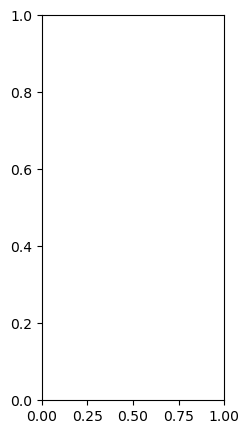

In [20]:
#Visualization of categorial data
i = 0
while i < 7:
    plt.figure(figsize=(8, 5))
    
    for j in range(3):
        if i < 6:
            plt.subplot(1, 3, j+1)
            sns.countplot(x=df_cat_name[i], data=df, palette="deep")
            plt.xlabel(str(df_cat_name[i]))
            i += 1
    
    if i == 6:
        plt.figure(figsize=(2.4, 5))
        plt.subplot(1, 1, 1)
        sns.countplot(x=df_cat_name[i], data=df, palette="deep")
        plt.xlabel(str(df_cat_name[i]))
        i += 1
    
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()

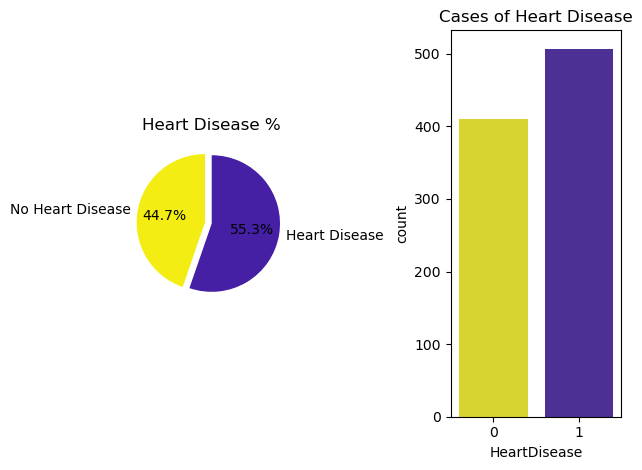

In [21]:
# Target Variable Layout
l = list(df['HeartDisease'].value_counts())
circle = [l[1] / sum(l) * 100, l[0] / sum(l) * 100]
colors = ['#F3ED13', '#451FA4']

plt.subplot(1, 2, 1)
plt.pie(circle, labels=['No Heart Disease', 'Heart Disease'], autopct='%1.1f%%', startangle=90, explode=(0.1, 0),
        colors=colors)
plt.title('Heart Disease %')

plt.subplot(1, 2, 2)
sns.countplot(x='HeartDisease', data=df, palette=colors)
plt.title('Cases of Heart Disease')

plt.tight_layout()
plt.show()

In [22]:


n = Normalizer()
n.fit(df)
df_norm = pd.DataFrame(n.transform(df),columns = df.columns)

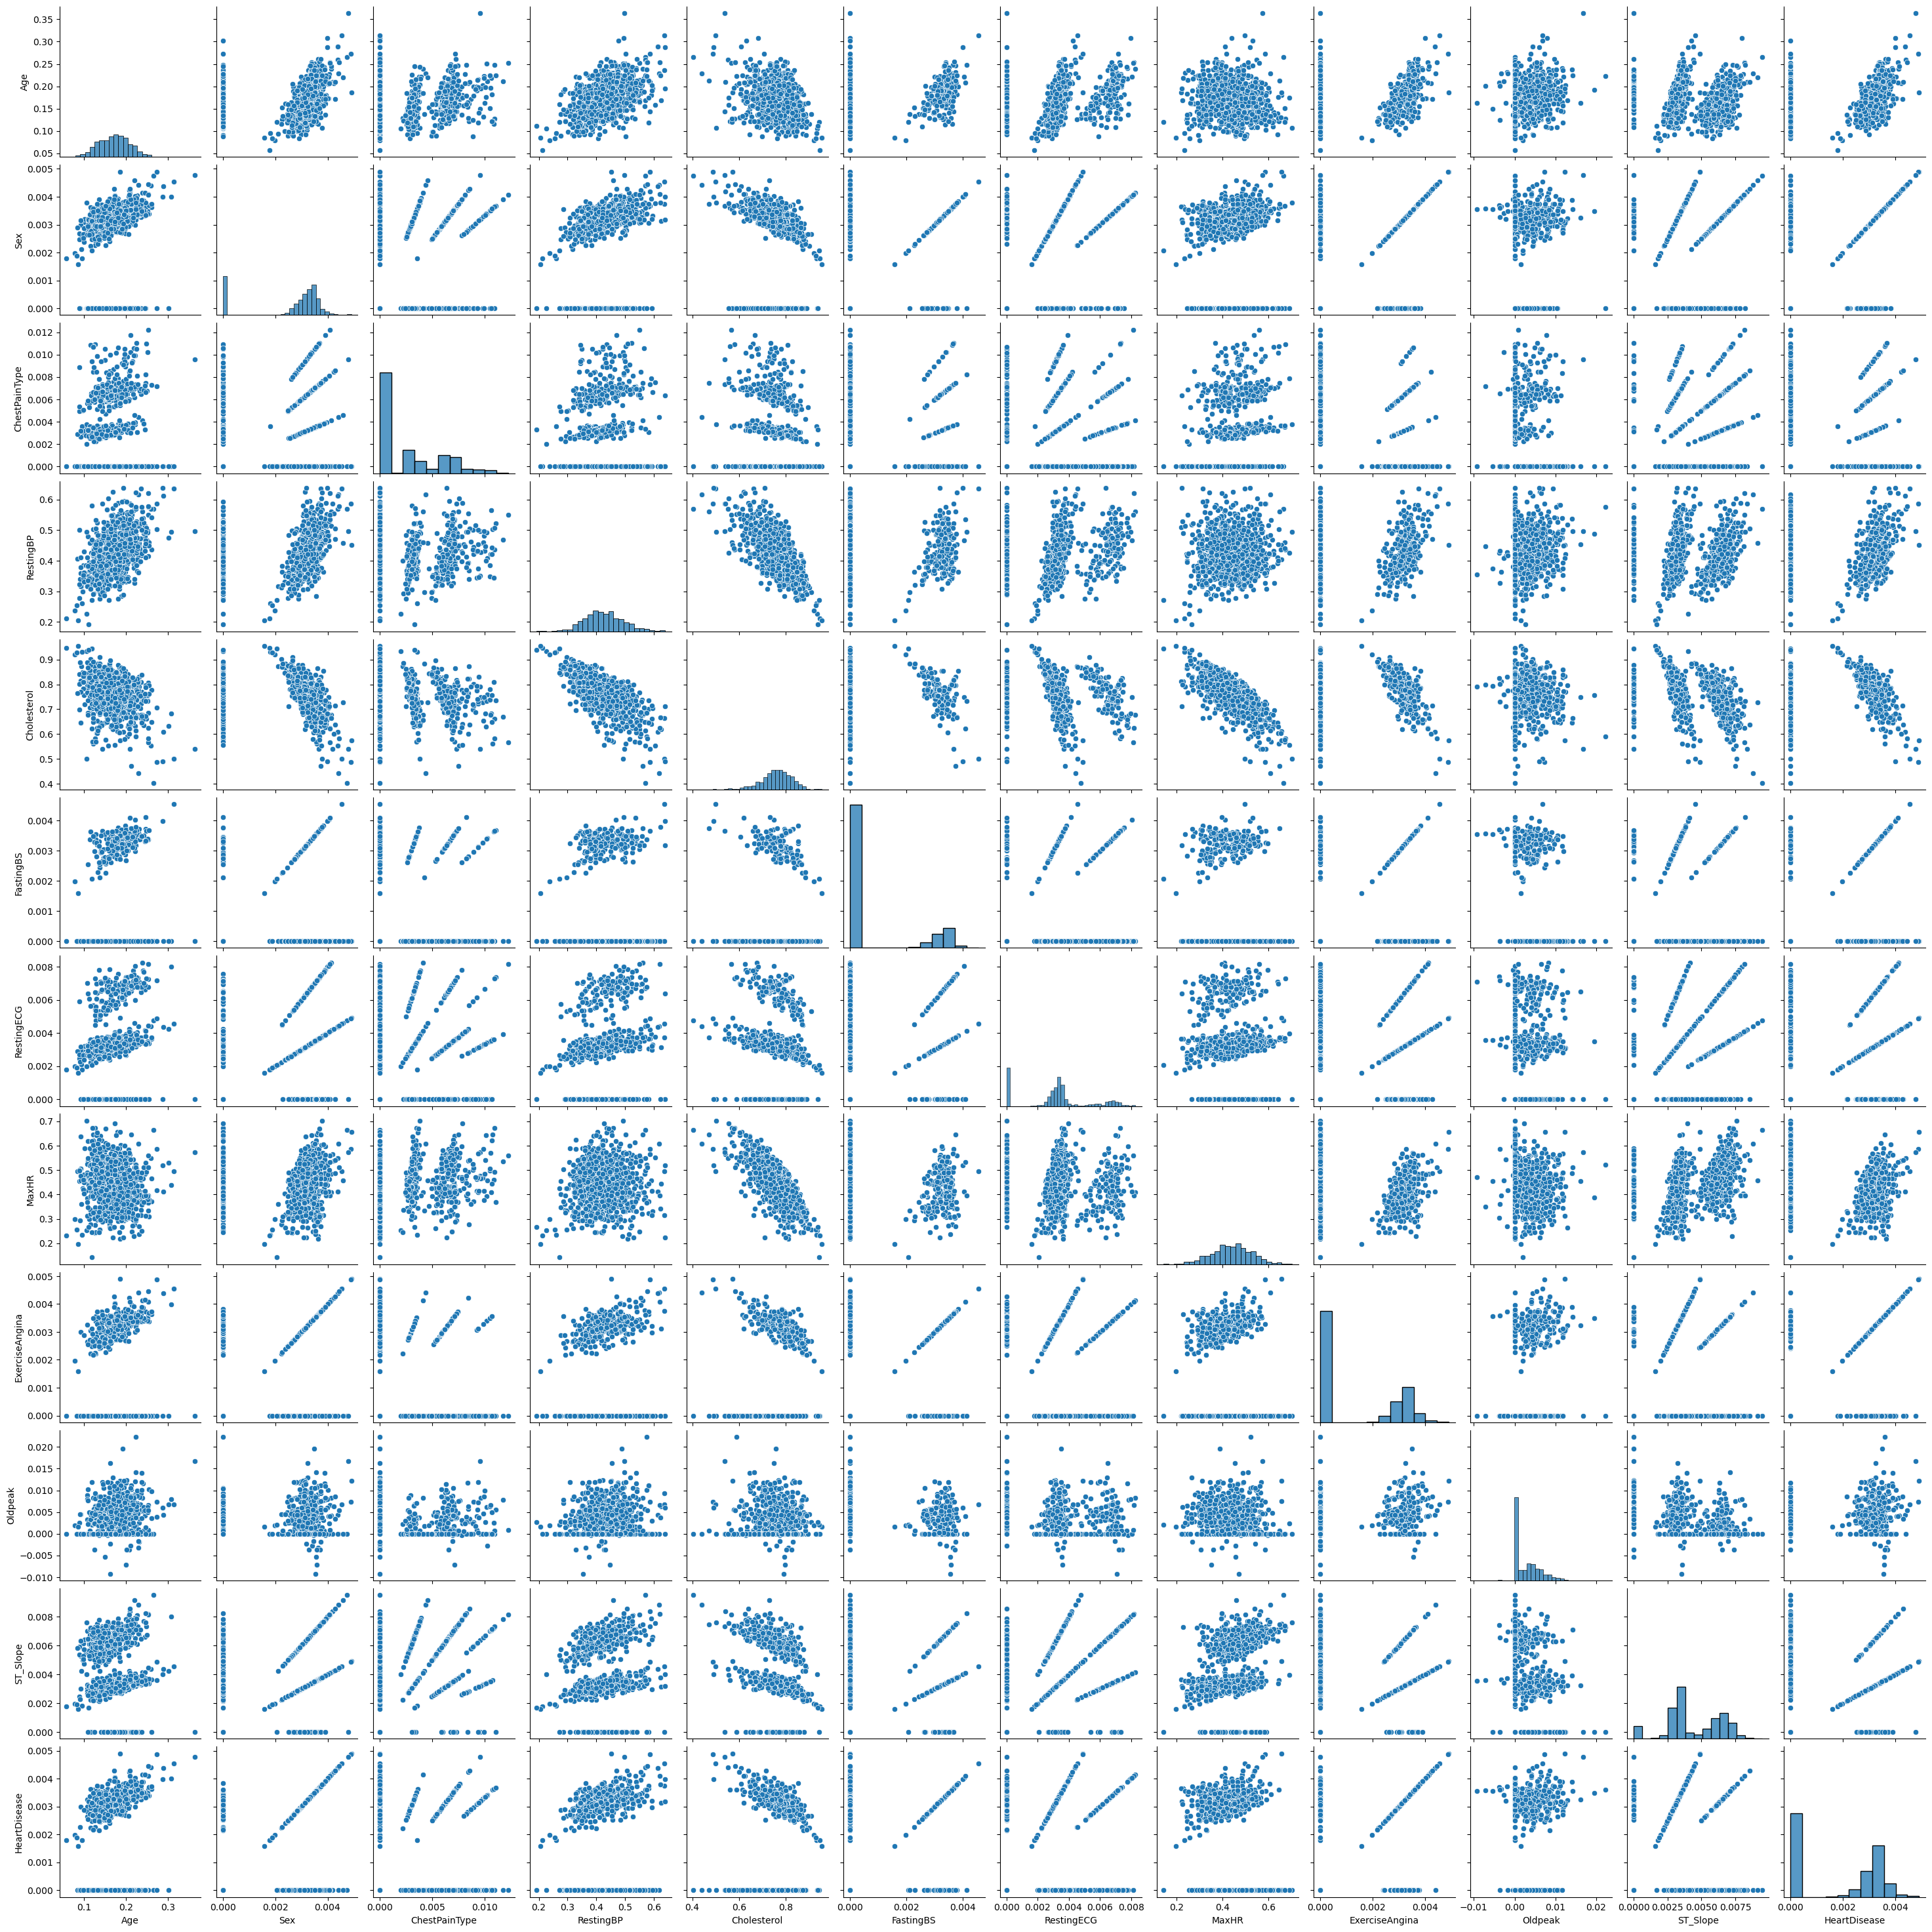

In [23]:
sns.pairplot(df_norm)

In [26]:
# Load the datase
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
print(f'Dataset has {X.shape[0]} data points and {X.shape[1]} features')

Dataset has 917 data points and 11 features


In [27]:
y.value_counts()

1    507
0    410
Name: HeartDisease, dtype: int64

In [100]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(X_train) 
x_test = scaler.fit_transform(X_test)

In [50]:
x_train = pd.DataFrame(X_train, columns=X.columns)
x_test = pd.DataFrame(X_test, columns=X.columns)

x train :



,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
378,70,1,0,140,223,1,1,157,1,2.0,1
356,46,1,0,115,223,0,1,113,1,1.5,1
738,65,0,2,160,360,0,0,151,0,0.8,2
85,66,1,0,140,139,0,1,94,1,1.0,1
427,59,1,0,140,223,0,2,117,1,1.0,1


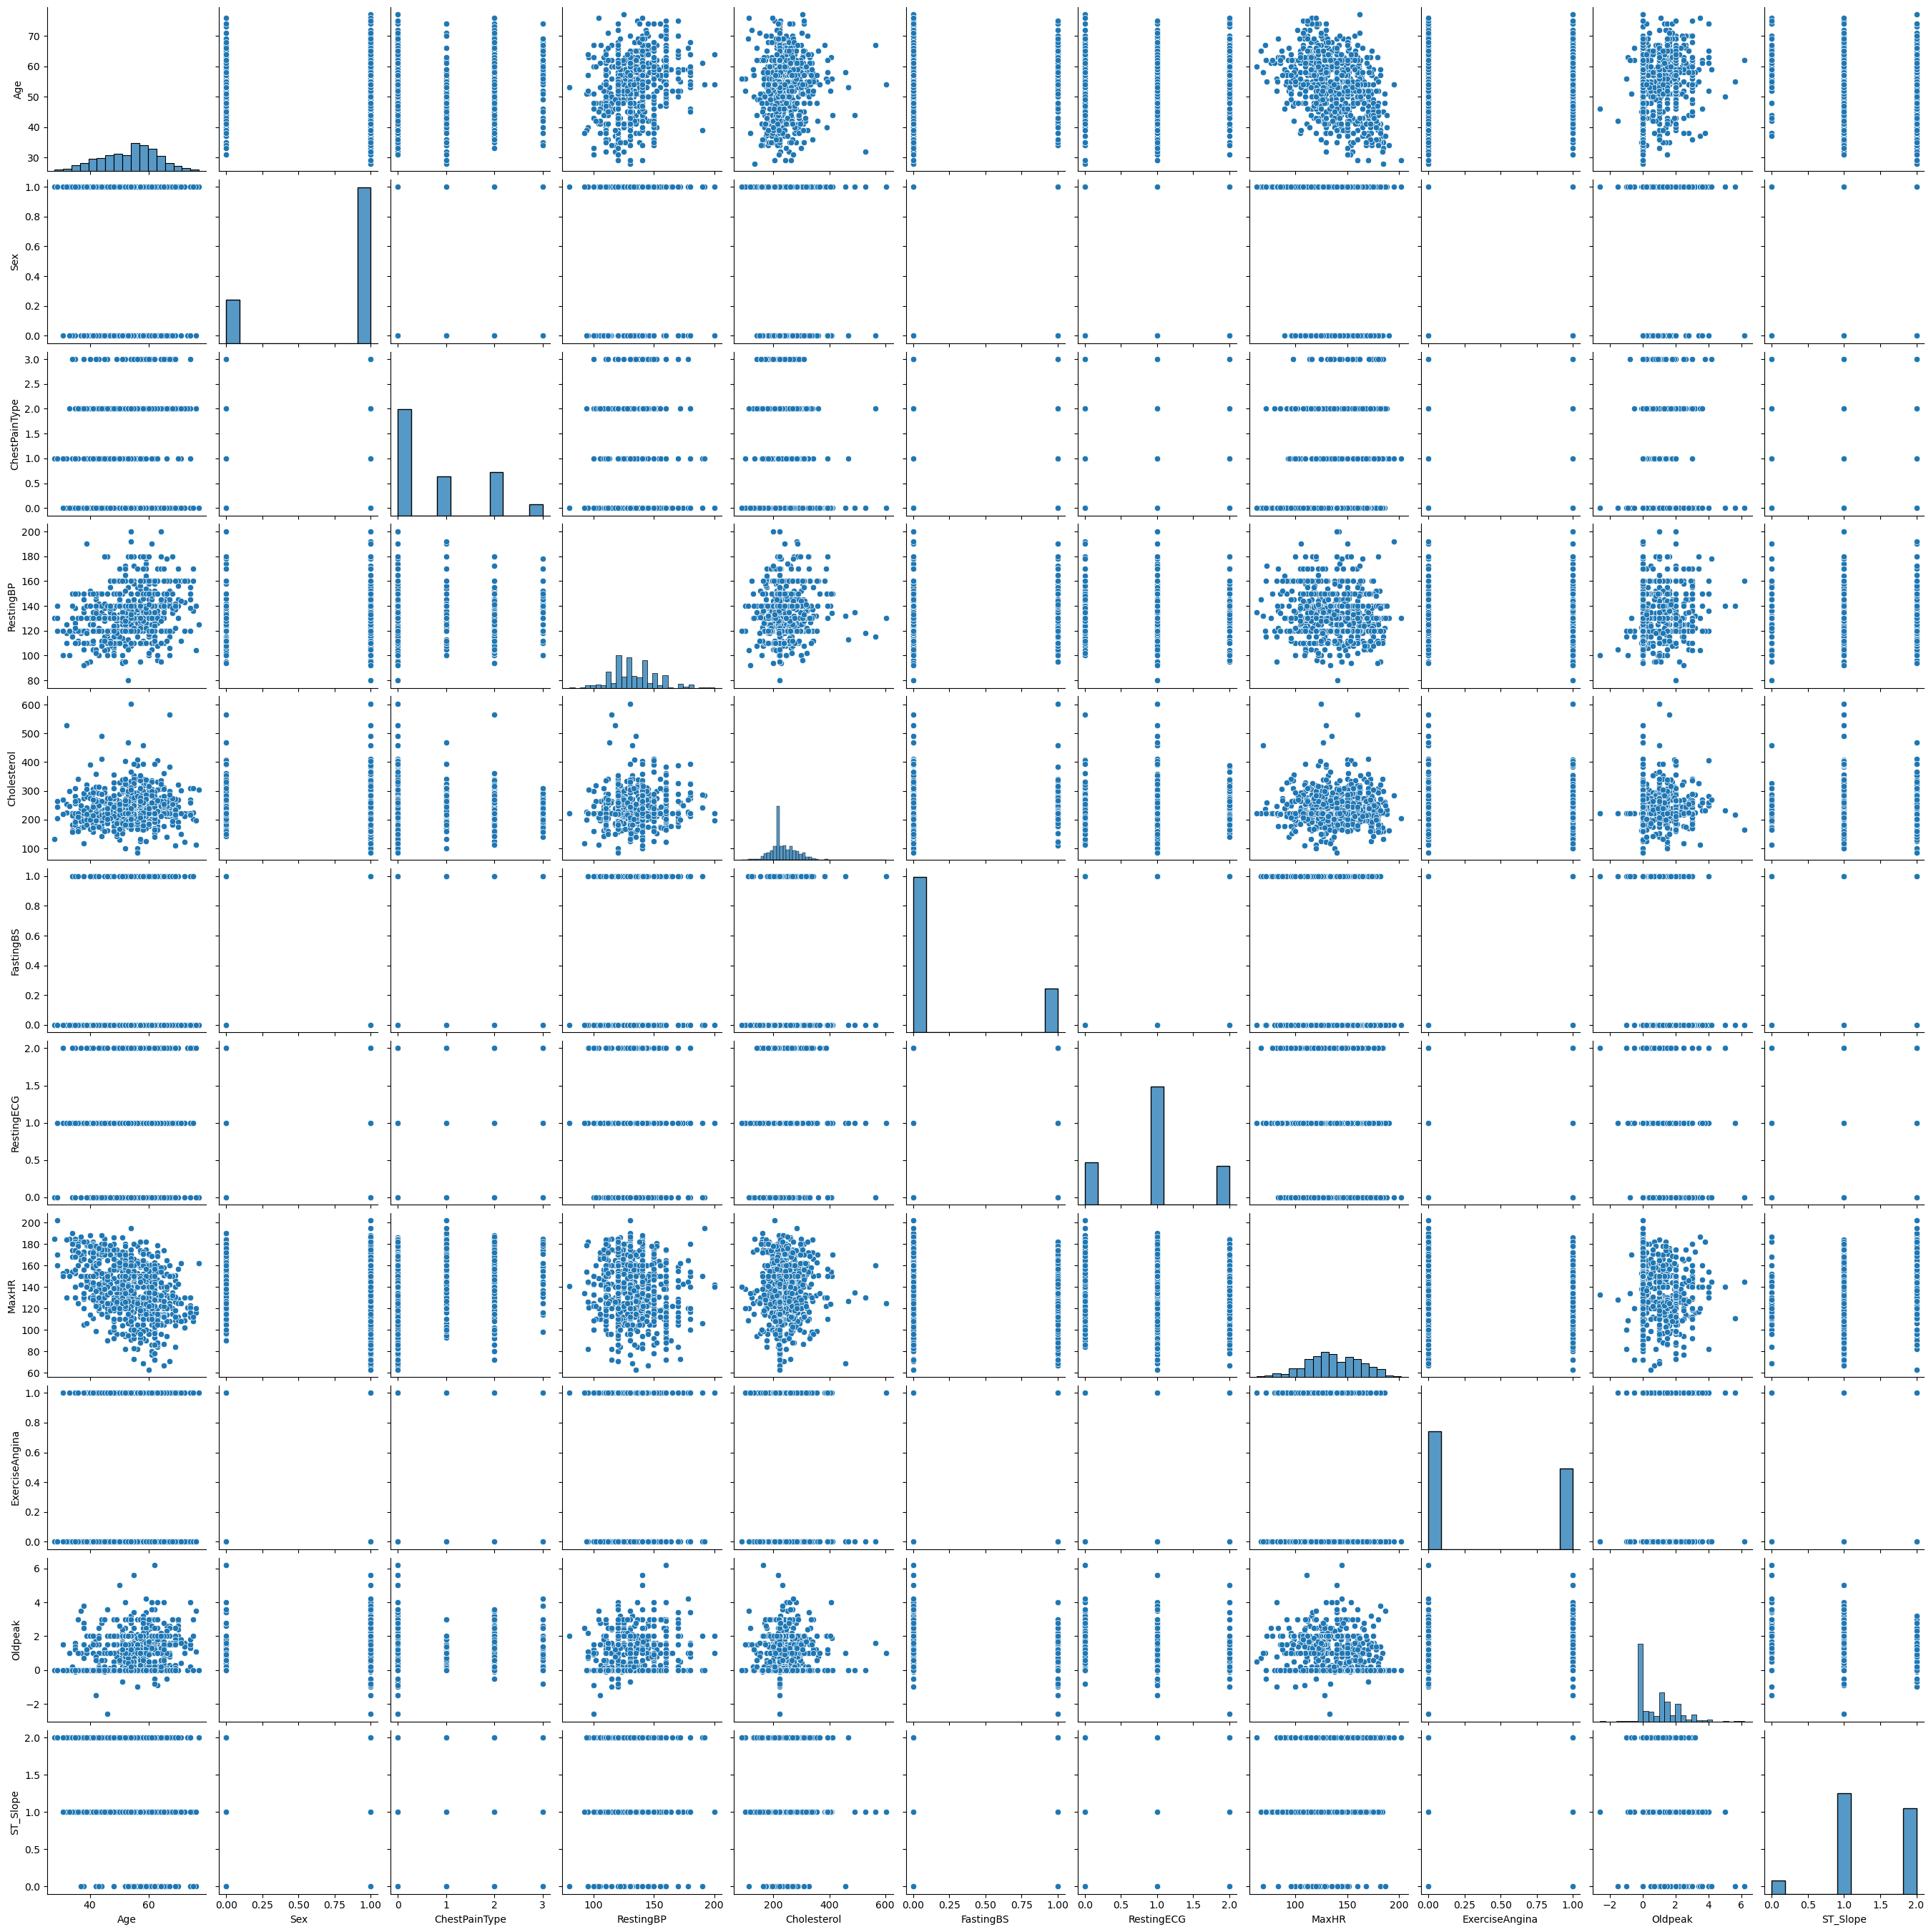

In [32]:
print("x train :\n")
display(x_train.head())
sns.pairplot(x_train)

x test :



,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0.627907,0.0,1.000000,0.466667,0.457045,0.0,0.5,0.163265,0.0,0.4,0.5
1,0.302326,1.0,0.000000,0.333333,0.000000,0.0,0.5,0.387755,1.0,0.4,0.5
2,0.232558,1.0,0.000000,0.333333,1.000000,1.0,0.5,0.714286,1.0,0.4,0.5
3,0.302326,1.0,0.000000,0.333333,0.006873,0.0,0.0,0.387755,1.0,1.0,0.5
4,0.651163,1.0,0.333333,0.413333,0.164948,1.0,0.5,0.285714,1.0,0.8,0.5


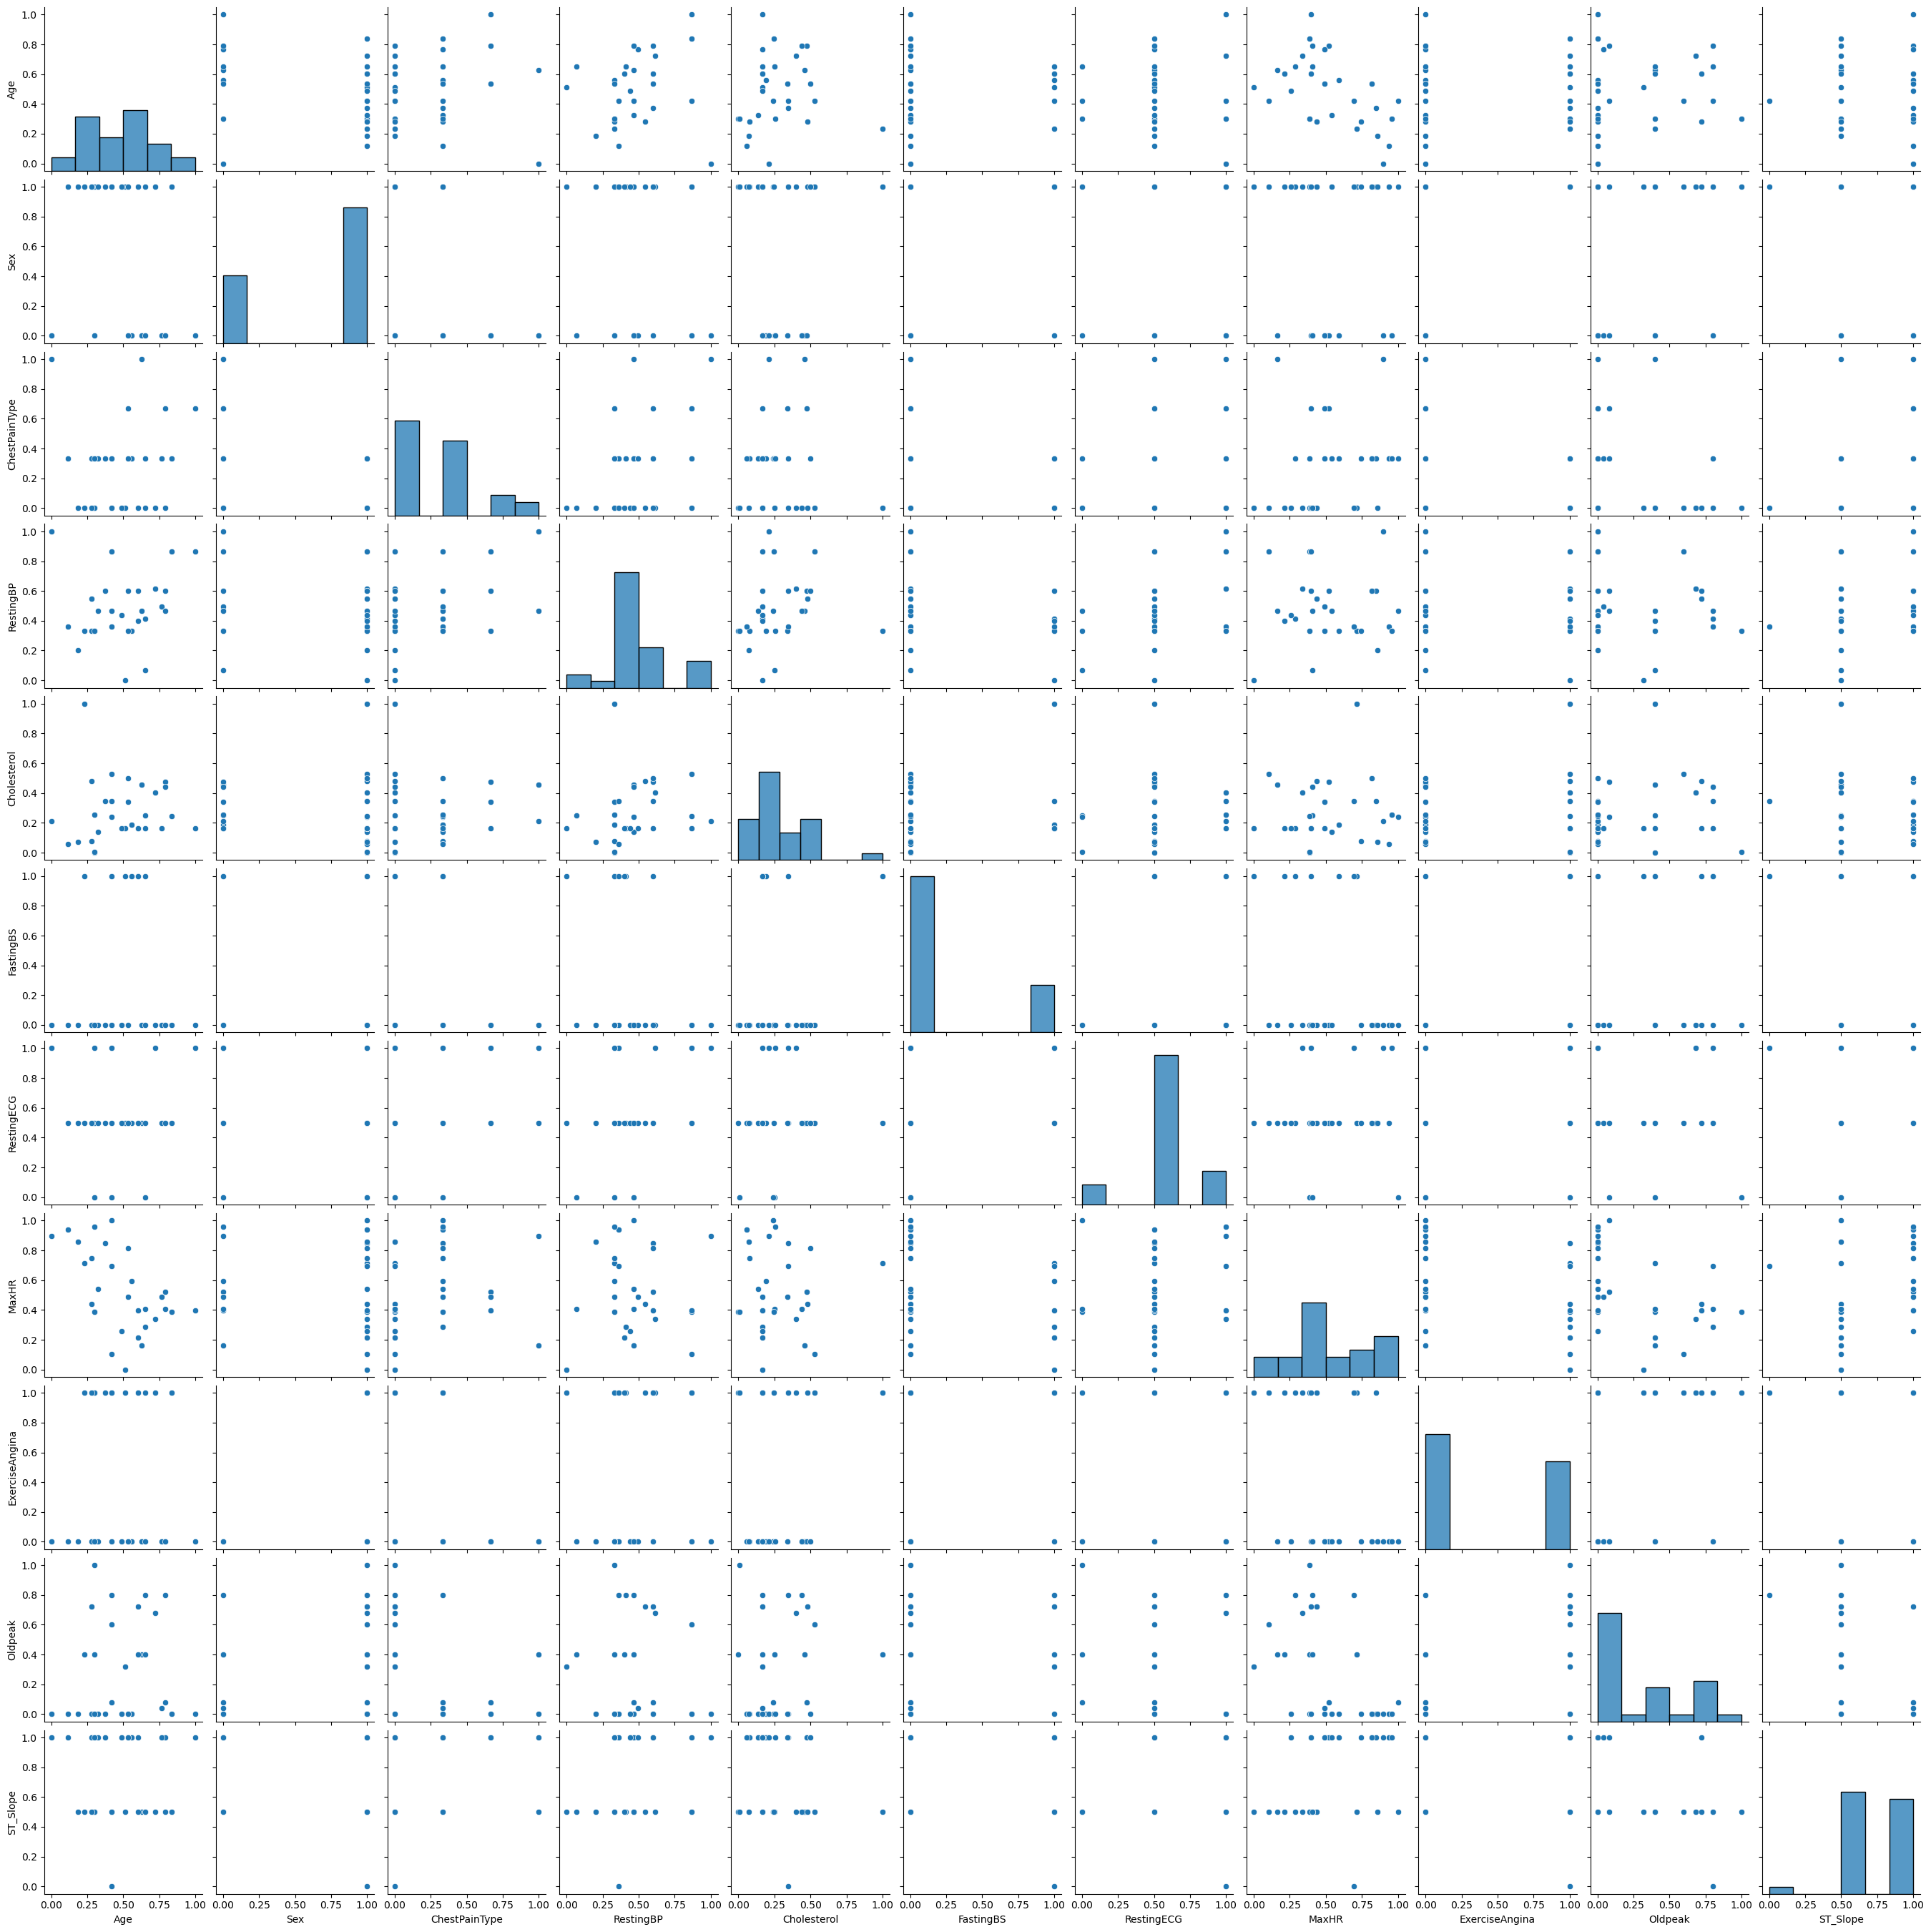

In [235]:
print("x test :\n")
display(x_test.head()) 
sns.pairplot(x_test)

 Logistic Regression

In [146]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

acc_train = log_reg.score(X_train,y_train)
print(f'acc train: {acc_train}')

acc_test = log_reg.score(X_test,y_test)
print(f'acc test: {acc_test}')


acc train: 0.8422764227642277
acc test: 0.834983498349835


In [147]:
log_reg.predict(X_test)

array([0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,

In [148]:
# ground truth
y_true = y_test

# simulate probabilites of positive class
y_proba =  log_reg.predict(X_test)

# set the threshold to predict positive class
thres = 0.5 

# class predictions
y_pred = [int(value > thres) for value in y_proba]


In [149]:
# compute confusion_matrix
confusion_matrix = confusion_matrix(y_true,y_pred)

print(confusion_matrix)

[[105  18]
 [ 32 148]]


In [150]:
# compute accuracy
accuracy_logi = accuracy_score(y_true,y_pred)

# print accuracy
print('Accuracy Score: %.3f'%(accuracy_logi))

Accuracy Score: 0.835


In [60]:
# compute F1-score
f1_score = f1_score(y_true,y_pred)

#print(f1_score)
print('F1-Score: %.3f'%(f1_score))

F1-Score: 0.868


In [61]:
# compute AUC-score
auc = roc_auc_score(y_true,y_proba)

# print AUC-score
print('ROC-AUC SCORE: %.2f'%(auc))


ROC-AUC SCORE: 0.84


In [64]:
# compute recall_score
recall_score = recall_score(y_true,y_proba)

# print recall_score
print('RECALL SCORE: %.2f'%(recall_score))


RECALL SCORE: 0.90


In [65]:
# compute precision_score
precision_score = precision_score(y_true,y_proba)

# print precision_score
print('PRECISION SCORE: %.2f'%(precision_score))


PRECISION SCORE: 0.84


In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82        82
           1       0.84      0.90      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



Support Vector Machine

In [152]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

train_svm = clf.score(X_train,y_train)
print(f'acc train: {train_svm}')

test_svm = clf.score(X_test,y_test)
print(f'acc test: {test_svm}')

#Predict the response for test dataset
y_pred_svm = clf.predict(X_test)


acc train: 0.8504065040650407
acc test: 0.8415841584158416


In [154]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy:
accuracy_svm = metrics.accuracy_score(y_true,y_pred_svm)
# print accuracy
print('Accuracy : %.3f'%(accuracy_svm))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred_svm))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred_svm))


Accuracy : 0.842
Precision: 0.8975903614457831
Recall: 0.8277777777777777


In [98]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81        82
           1       0.83      0.90      0.86       102

    accuracy                           0.84       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



Desicion Tree

In [159]:
from sklearn.tree import DecisionTreeClassifier

clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=0) #Descition Tree model


# fit the model
clf_gini.fit(X_train, y_train)

train_tree = clf_gini.score(X_train,y_train)
print(f'acc train: {train_tree}')

test_tree = clf_gini.score(X_test,y_test)
print(f'acc test: {test_tree}')



acc train: 0.9121951219512195
acc test: 0.7920792079207921


In [161]:
y_pred_gini = clf_gini.predict(X_test) #Prediction

# Model Accuracy:
accuracy_decsion = accuracy_score(y_true,y_pred_gini)
# print accuracy
print('Model accuracy score with criterion gini index:  %.4f'%(accuracy_decsion))

Model accuracy score with criterion gini index:  0.7921


[Text(0.49609375, 0.9285714285714286, 'X[9] <= 1.5\ngini = 0.498\nsamples = 615\nvalue = [287, 328]'),
 Text(0.2515625, 0.7857142857142857, 'X[2] <= 2.5\ngini = 0.305\nsamples = 319\nvalue = [60, 259]'),
 Text(0.159375, 0.6428571428571429, 'X[6] <= 135.5\ngini = 0.479\nsamples = 83\nvalue = [33, 50]'),
 Text(0.09375, 0.5, 'X[0] <= 65.0\ngini = 0.295\nsamples = 39\nvalue = [7, 32]'),
 Text(0.05, 0.35714285714285715, 'X[0] <= 44.0\ngini = 0.18\nsamples = 30\nvalue = [3, 27]'),
 Text(0.025, 0.21428571428571427, 'X[2] <= 1.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.0125, 0.07142857142857142, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.0375, 0.07142857142857142, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.075, 0.21428571428571427, 'X[4] <= 317.0\ngini = 0.133\nsamples = 28\nvalue = [2, 26]'),
 Text(0.0625, 0.07142857142857142, 'gini = 0.077\nsamples = 25\nvalue = [1, 24]'),
 Text(0.0875, 0.07142857142857142, 'gini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.13

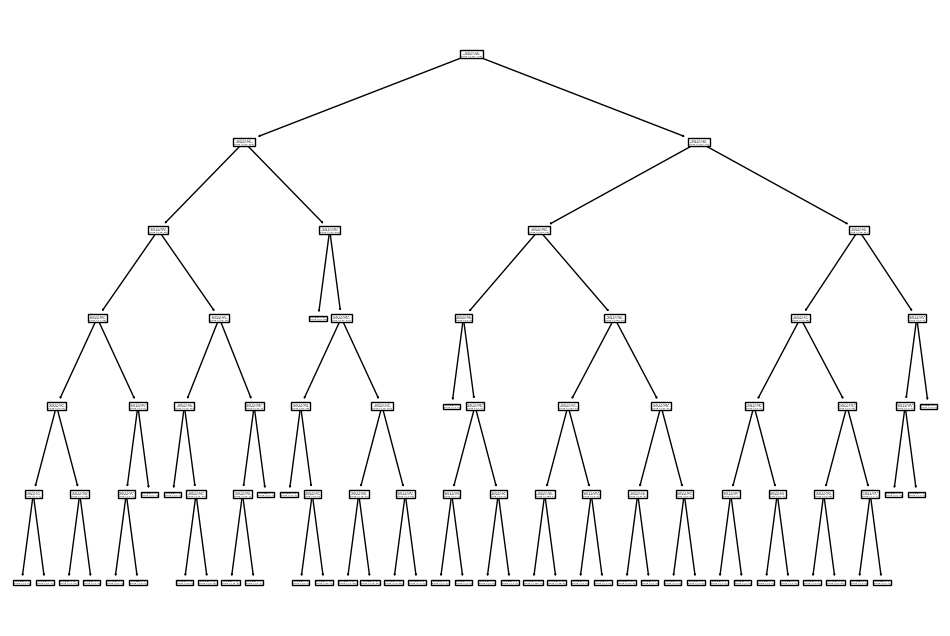

In [162]:
plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(clf_gini.fit(X_train, y_train))

In [163]:
print(classification_report(y_test, y_pred_gini))

              precision    recall  f1-score   support

           0       0.71      0.82      0.76       123
           1       0.86      0.77      0.82       180

    accuracy                           0.79       303
   macro avg       0.79      0.80      0.79       303
weighted avg       0.80      0.79      0.79       303



Random Forest

In [185]:
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0)
# fit the model
rfc.fit(X_train, y_train)

train_random = rfc.score(X_train,y_train)
print(f'acc train: {train_random}')

test_random = rfc.score(X_test,y_test)
print(f'acc test: {test_random}')

# Predict the Test set results
y_pred_random = rfc.predict(X_test)

# Check accuracy score
accuracy_random_10 = accuracy_score(y_true,y_pred_random)
print('Model accuracy score with 10 decision-trees:  %.4f'%(accuracy_random_10))

acc train: 1.0
acc test: 0.8646864686468647
Model accuracy score with 10 decision-trees:  0.8647


Until now, I have used all the features given in the model. Now, I will select only the important features, build the model using these features and see its effect on accuracy.

First, I will create the Random Forest model as follows:-

In [186]:
# create the classifier with n_estimators = 100

clf = RandomForestClassifier(n_estimators=100, random_state=0)
# fit the model to the training set

clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [187]:
# view the feature scores

feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

ST_Slope          0.237623
Oldpeak           0.141798
Cholesterol       0.108391
MaxHR             0.104602
ExerciseAngina    0.101728
ChestPainType     0.091869
Age               0.091320
RestingBP         0.072201
Sex               0.026221
RestingECG        0.024248
dtype: float64

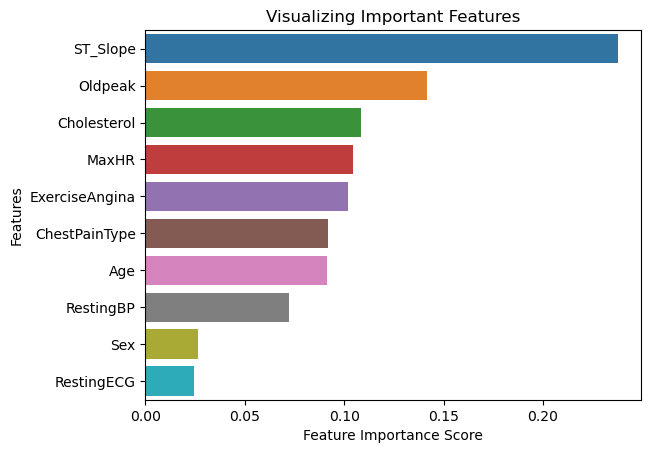

In [188]:
# Creating a seaborn bar plot
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [189]:
# declare feature vector and target variable

X = df.drop(['HeartDisease', 'FastingBS'], axis=1)

y = df['HeartDisease']

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [191]:
# encode categorical variables with ordinal encoding
import category_encoders as ce


encoder = ce.OrdinalEncoder(cols=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])


X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

In [192]:
# instantiate the classifier with n_estimators = 100

clf = RandomForestClassifier(random_state=0)

# fit the model to the training set

clf.fit(X_train, y_train)

train_clf = clf.score(X_train,y_train)
print(f'acc train: {train_clf}')

test_clf = clf.score(X_test,y_test)
print(f'acc test: {test_clf}')

# Predict on the test set results
y_pred_100 = clf.predict(X_test)
# Check accuracy score 
accuracy_random_100 = accuracy_score(y_true,y_pred_100)
# print accuracy
print('Model accuracy score with 100 decision-trees:  %.4f'%(accuracy_random_100))


acc train: 1.0
acc test: 0.8646864686468647
Model accuracy score with 100 decision-trees:  0.8647


The model accuracy score with 10 decision-trees is 0.8478 but the same with 100 decision-trees is 0.8647. So, as expected accuracy increases with number of decision-trees in the model.

In [172]:
print(classification_report(y_test, y_pred_100))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       123
           1       0.92      0.85      0.88       180

    accuracy                           0.86       303
   macro avg       0.86      0.87      0.86       303
weighted avg       0.87      0.86      0.87       303



XGBOOST Classifier

In [180]:
xgb = XGBClassifier(max_depth = 7 , learning_rate = 0.25 , objective = 'binary:logistic' , n_estimators= 5, random_state=42)


In [181]:
xgb.fit(X_train , y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=5, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [182]:
train_xgb = xgb.score(X_train , y_train)
print(f'acc train: {train_xgb}')

test_xgb = xgb.score(X_test , y_test)
print(f'acc train: {test_xgb}')

y_pred_xgb = xgb.predict(X_test)

accuracy_xgboost = accuracy_score(y_true,y_pred_xgb)
print('Model accuracy score XGBOOST Classifier :  %.4f'%(accuracy_xgboost))

acc train: 0.9447154471544715
acc train: 0.8316831683168316
Model accuracy score XGBOOST Classifier :  0.8317


Voting Classifier Model


In [196]:
m1 = LogisticRegression(max_iter=1000)
m2 = svm.SVC(kernel='linear')
m3 = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=0)
m4 = RandomForestClassifier(random_state=0)
m5 = XGBClassifier(max_depth = 7 , learning_rate = 0.25 , objective = 'binary:logistic' , n_estimators= 5, random_state=42)


In [199]:
v_clf = VotingClassifier(estimators=[("LogisticRegression" , m1) , ('svm' , m2) ,
                                     ("DecisionTreeClassifier" , m3) ,("RandomForestClassifier" , m4),
                                       ("XGBClassifier" , m5)] , voting = "hard")

In [200]:
v_clf.fit(X_train , y_train)

VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(max_iter=1000)),
                             ('svm', SVC(kernel='linear')),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier(max_depth=6,
                                                     random_state=0)),
                             ('RandomForestClassifier',
                              RandomForestClassifier(random_state=0)),
                             ('XGBClassifier',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_byleve...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                         

In [204]:
train_voting = v_clf.score(X_train , y_train)
print(f'acc train: {train_voting}')
test_voting = v_clf.score(X_test , y_test)
print(f'acc train: {test_voting}')

y_pred_voting = v_clf.predict(X_test)

accuracy_voting = accuracy_score(y_true,y_pred_voting)
print('Model accuracy score Voting Classifier :  %.4f'%(accuracy_voting))


acc train: 0.926829268292683
acc train: 0.8679867986798679
Model accuracy score Voting Classifier :  0.8680


Model Comparison

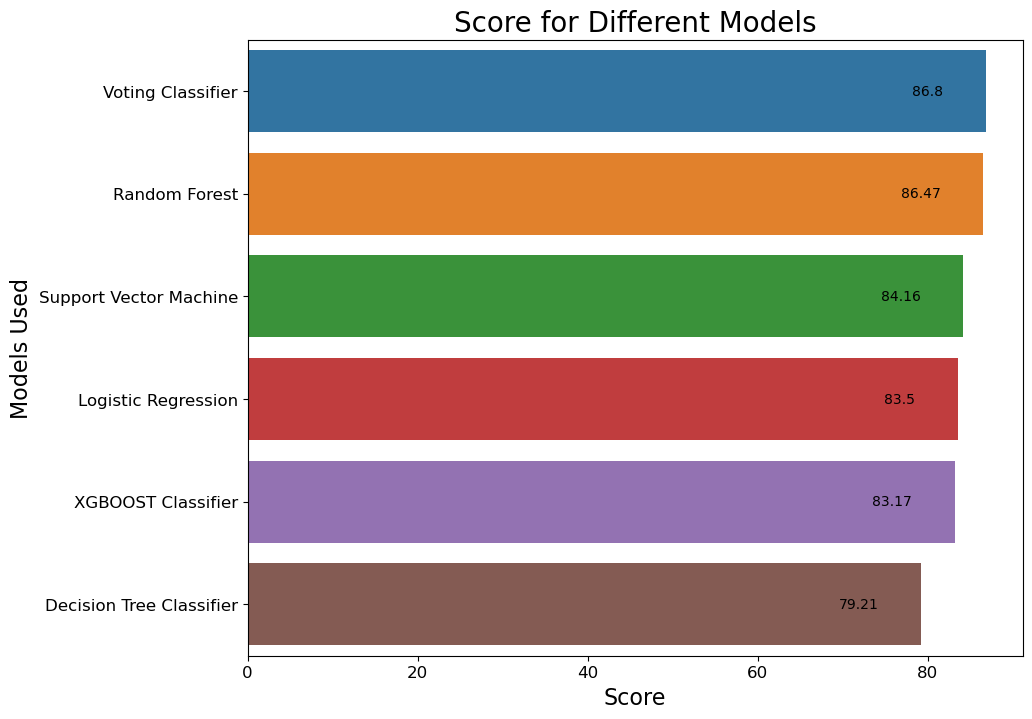

In [205]:
data = {
    'Logistic Regression': accuracy_logi * 100,
    'Support Vector Machine': accuracy_svm * 100,
    'Decision Tree Classifier': accuracy_decsion * 100,
    'Random Forest': accuracy_random_10 * 100,
    'XGBOOST Classifier': accuracy_xgboost * 100,
    'Voting Classifier' : accuracy_voting * 100,
}

# Sort the dictionary by values in descending order
data = dict(sorted(data.items(), key=lambda x: x[1], reverse=True))

models = list(data.keys())
score = [round(val, 2) for val in data.values()]

fig = plt.figure(figsize=(10, 8))
ax = sns.barplot(x=score, y=models)

# Add rounded accuracy scores on the left side of each bar
for i in range(len(score)):
    ax.text(score[i] - 5, i, str(score[i]), ha='right', va='center', color='black', fontweight='light')

plt.xlabel("Score", size=16)
plt.xticks(size=12)
plt.ylabel("Models Used", size=16)
plt.yticks(size=12)
plt.title("Score for Different Models", size=20)
plt.show()